# Rare variants

This analysis aimed to answer the following research question: **What is the prevalence of rare variants within African populations, and do specific populations exhibit a higher rare variant burden?**

To answer this question, the following steps were performed: 

1. Data Generation: Genetic variation data was generated from genetic information obtained from the [GnomAD 1000 Genomes and HGDP datasets](https://gnomad.broadinstitute.org/news/2021-10-gnomad-v3-1-2-minor-release/) for African population groups.
2. Data Preparation: The generated genetic variation data was processed and prepared for analysis following the steps detailed in the [Notebooks\Data_preparation\2-IH_allele_counts.ipynb](https://github.com/MeganHolborn/Genetic_data_analysis/blob/main/Notebooks/Data_preparation/) Jupyter notebook. The resulting prepared data included variant positional information, allele counts, and frequencies, which are stored [here](https://github.com/MeganHolborn/Genetic_data_analysis/blob/main/Data/Processed/IH_allele_counts.csv). Additionally, metadata on the individuals from which genetic variation data was generated, was prepared and stored [here](https://github.com/MeganHolborn/Genetic_data_analysis/blob/main/Data/Processed/Sample_populations.csv). 
3. Analysis and Visualisation: 
    * Genetic variant frequencies were segmented into distinct bins. The variant data was then grouped by frequency bin and ethnolinguistic population group. The distribution of variant frequencies within the different population groups was visualised using a bar plot with the grouped data as input. 
    * The amount and percentage of rare variants within each ethnolinguistic population was calculated, along with the overall amount and percentage of rare variants across all populations.


## Imports

Notebook setup

In [34]:
import os
import sys

from dotenv import load_dotenv

load_dotenv()

PROJECT_ROOT = os.getenv("PROJECT_ROOT")
if PROJECT_ROOT not in sys.path:
    os.chdir(PROJECT_ROOT + "/Notebooks")
    sys.path.append(PROJECT_ROOT)

import numpy as np
import pandas as pd
import seaborn as sns
import upsetplot
from matplotlib import pyplot as plt
import Utils.constants as constants
import Utils.functions as functions

Import variant allele count data

In [35]:
ih_allele_counts = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Data",
        "Processed",
        "IH_allele_counts.csv",
    )
)

ih_allele_counts

,ID,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,IH_REF_CTS,REG,IH_AF,VARIANT_TYPE
0,110148882_CT_C,chr13:110148882C-CT,110148882,C,CT,COL4A1,Bantu Kenya,0,20,20,EA,0.0,INDEL
1,110148882_CT_C,chr13:110148882C-CT,110148882,C,CT,COL4A1,Yoruba,0,276,276,WA,0.0,INDEL
2,110148882_CT_C,chr13:110148882C-CT,110148882,C,CT,COL4A1,San,0,12,12,SA,0.0,INDEL
3,110148882_CT_C,chr13:110148882C-CT,110148882,C,CT,COL4A1,Mende,0,166,166,WA,0.0,INDEL
4,110148882_CT_C,chr13:110148882C-CT,110148882,C,CT,COL4A1,Mbuti Pygmy,0,24,24,CA,0.0,INDEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259291,48256362_T_G,chr19:48256362G-T,48256362,G,T,CARD8,Mandinka,0,232,232,WA,0.0,SNP
259292,48256362_T_G,chr19:48256362G-T,48256362,G,T,CARD8,Mbuti Pygmy,0,24,24,CA,0.0,SNP
259293,48256362_T_G,chr19:48256362G-T,48256362,G,T,CARD8,Mende,0,164,164,WA,0.0,SNP
259294,48256362_T_G,chr19:48256362G-T,48256362,G,T,CARD8,Yoruba,0,272,272,WA,0.0,SNP


## Analysis and visualisation

### Data selection

Select allele frequencies for subpopulation groups

In [36]:
ih_afr_subpops = ih_allele_counts[
    ~((ih_allele_counts.REG == "Recent African"))
]

Remove variants with an alt allele count of 0. These variants are not present in a particular subpopulation group.

In [37]:
ih_afr_subpops = ih_afr_subpops[ih_afr_subpops.IH_AF > 0]

### Data grouping

Divide allele frequencies into quantiles

In [38]:
ih_afr_subpops["QUANTILE"] = pd.cut(
    ih_afr_subpops["IH_AF"],
    [0.0, 0.001, 0.005, 0.05, 0.5, 1.0],
    labels=[
        "< 0.001",
        "0.001-0.005",
        "0.005-0.05",
        "0.05-0.5",
        "> 0.5",
    ],
)
ih_afr_subpops.head()

,ID,VAR_NAME,POS,REF,ALT,GENE,SUB_POP,IH_ALT_CTS,IH_TOTAL_CTS,IH_REF_CTS,REG,IH_AF,VARIANT_TYPE,QUANTILE
13,110148891_G_C,rs552586867,110148891,C,G,COL4A1,Yoruba,1,276,275,WA,0.003623,SNP,0.001-0.005
24,110148917_G_C,rs59409892,110148917,C,G,COL4A1,Yoruba,29,276,247,WA,0.105072,SNP,0.05-0.5
26,110148917_G_C,rs59409892,110148917,C,G,COL4A1,Mende,15,166,151,WA,0.090361,SNP,0.05-0.5
27,110148917_G_C,rs59409892,110148917,C,G,COL4A1,Mbuti Pygmy,1,24,23,CA,0.041667,SNP,0.005-0.05
29,110148917_G_C,rs59409892,110148917,C,G,COL4A1,Mandenka,7,40,33,WA,0.175000,SNP,0.05-0.5


#### Generate summary statistics for the variant frequencies. 
It is very important that the max allele frequency does not exceed 1. 

In [39]:
ih_afr_subpops["IH_AF"].describe()

count    38284.000000
mean         0.185956
std          0.243285
min          0.003623
25%          0.021739
50%          0.082471
75%          0.250000
max          1.000000
Name: IH_AF, dtype: float64

Verify the number of unique variants

In [40]:
ih_afr_subpops["ID"].nunique()

8867

#### Visualise the variant frequency distribution for each population group

Group data by frequency quantile and subpopulation

In [41]:
ih_afr_subpops_binned_grouped = (
    functions.group_and_count(
        data=ih_afr_subpops[["QUANTILE", "SUB_POP", "ID"]],
        group_columns=["QUANTILE", "SUB_POP"],
    )
    .reset_index()
    .rename(columns={"ID": "COUNT"})
)
ih_afr_subpops_binned_grouped.tail(5)

,QUANTILE,SUB_POP,COUNT
50,> 0.5,Mandinka,384
51,> 0.5,Mbuti Pygmy,458
52,> 0.5,Mende,377
53,> 0.5,San,386
54,> 0.5,Yoruba,388


Pivot data

In [42]:
# Pivot data before plotting

ih_afr_subpops_binned_pivot = ih_afr_subpops_binned_grouped.pivot(
    index="SUB_POP", columns="QUANTILE", values="COUNT"
)

ih_afr_subpops_binned_pivot

QUANTILE,< 0.001,0.001-0.005,0.005-0.05,0.05-0.5,> 0.5
SUB_POP,,,,,
Bantu Kenya,0,0,568,1392,413
Bantu South Africa,0,0,0,2007,357
Biaka Pygmy,0,0,1046,1676,417
Esan,0,739,1564,1653,401
Luhya,0,0,2602,1630,398
Mandenka,0,0,906,1505,377
Mandinka,0,1018,1659,1692,384
Mbuti Pygmy,0,0,668,1468,458
Mende,0,0,2321,1718,377


Set plot parameters

In [43]:
sns.set(rc={"figure.figsize": (10, 8)})  # set plot size

plt.rc("font", size=constants.MEDIUM_FONT)  # controls default text sizes
plt.rc("axes", titlesize=constants.MEDIUM_FONT)  # fontsize of the axes title
plt.rc("axes", labelsize=constants.BIGGER_FONT)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=constants.MEDIUM_FONT)  # fontsize of the tick labels
plt.rc("legend", fontsize=constants.MEDIUM_FONT)  # legend fontsize
plt.rc("figure", titlesize=constants.BIGGER_FONT)  # fontsize of the figure title

Generate a barplot to visualise variant frequency distribution for each gene

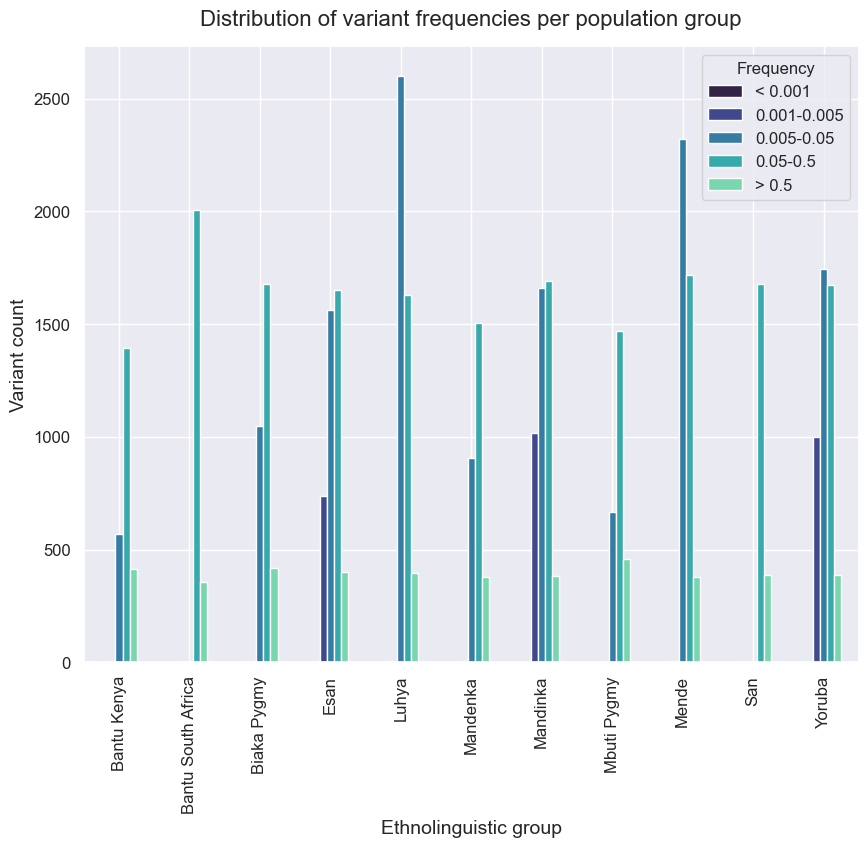

In [44]:
palette = sns.set_palette("mako", 5)

ih_afr_subpops_binned_pivot.plot.bar(logy=False, color=palette)

plt.xlabel("Ethnolinguistic group")

plt.ylabel("Variant count")

plt.legend(loc="upper right", frameon=True, title="Frequency")

plt.title(
    "Distribution of variant frequencies per population group",
    size=constants.LARGEST_FONT,
    pad=15,
)

plt.savefig("..\Results\Figures\Variant_frequencies.png", dpi=1200, bbox_inches="tight")

plt.show()

What percentage of variants found in all populations were rare, occuring at frequency below 0.005 in a particular population? African populations often contain higher amounts of rare variants compared to other global populations due to the incredible amount of genetic diversity in the African population.

In [45]:
rare_variants = ih_afr_subpops[ih_afr_subpops["IH_AF"] < 0.005]["ID"].nunique()
all_variants = ih_afr_subpops["ID"].nunique()

rare_variants

2463

In [46]:
rare_variant_percentage = (rare_variants / all_variants) * 100
rare_variant_percentage

27.77715123491598

Over 27% of variants detected in the African populations were rare to a particular subpopulation. Note, that although these variants occur at a low frequency within a particular subpopulation group, they may not be rare in a broader population (e.g., Africans overall). The opposite may also be true, where variants that are not rare within particular population groups are rare in Africans overall.

Filter data for variants with rare frequencies

In [47]:
ih_afr_subpops_rare = ih_afr_subpops[ih_afr_subpops["IH_AF"] < 0.005]

In which subpopulations were rare variants found?

In [48]:
ih_afr_subpops_rare["SUB_POP"].unique()

array(['Yoruba', 'Esan', 'Mandinka'], dtype=object)

Get the count of rare variants for each subpopulation. To do this, group by subpopulation.

In [49]:
rare_count = ih_afr_subpops_rare[["SUB_POP", "ID"]].groupby("SUB_POP").count()
rare_count = rare_count.rename(columns={"ID": "RARE_COUNT"})

rare_count

,RARE_COUNT
SUB_POP,
Esan,724
Mandinka,1015
Yoruba,996


All the rare variants seem to originate from three population groups, namely, the Yoruban group that was sampled by 1000 Genomes (note: some of the Yoruban samples came from the HGDP dataset), the Esan and Mandinka populations. Interestingly, these populations in which rare variants wer detected also the largest sample counts. It is possible that rare variants were detected in these variants that were not detected in other populations due to large sample counts.

Are any of the rare variants found in the populations, potentially novel? Variants will be classified as potentially novel if they do not have a [NCBI dbSNP rsID](https://customercare.23andme.com/hc/en-us/articles/212196908-What-Are-RS-Numbers-Rsid-#:~:text=The%20rsID%20number%20is%20a,convention%20used%20for%20most%20SNPs).

In [50]:
# Filter for rare variants without rsIDs

potential_novel_variants = ih_afr_subpops_rare[
    ~(ih_afr_subpops_rare.VAR_NAME.str.contains("rs"))
]

# Count the number of potentially novel, rare variants

potential_novel_variants["ID"].nunique()

685

What is the percentage novel variants of all rare variants

In [51]:
potential_novel_variants["ID"].nunique()/rare_variants

0.2781161185546082